# Working with priors

In Bayesian statistics a prior is used to specify prior belief.
Working with priors to improve estimates of undersampled populations.
Priors can be based on other related, populations, or specified by
hand.

In [1]:
import HLAfreq
import HLAfreq.HLAfreq_pymc as HLAhdi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Venezuela is one of the least sampled countries on allelefrequency.net
We found only 55 gold standard samples for HLA A.

In [2]:
# Download data for Venezuela
country = "Venezuela"
base_url = HLAfreq.makeURL(country, locus="A", standard="g",)
venezuelaAF = HLAfreq.getAFdata(base_url)

1 pages of results
Download complete


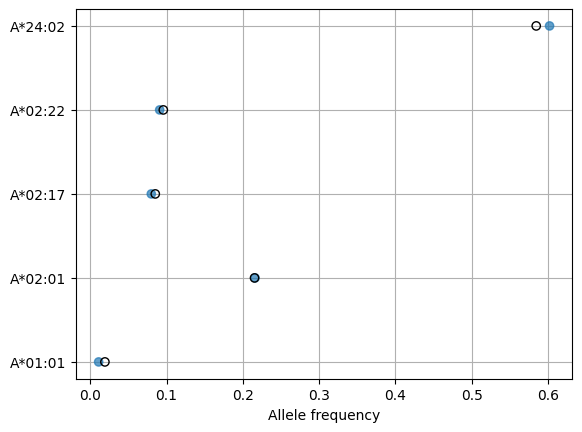

In [3]:
venezuelaAF = HLAfreq.only_complete(venezuelaAF)
venezuelaAF = HLAfreq.decrease_resolution(venezuelaAF, 2)
cafV = HLAfreq.combineAF(venezuelaAF)
cafV['study'] =  'Venezuela'
HLAfreq.plotAF(cafV, venezuelaAF)

We can specify priors manually, this could be any
$n$ length list of positive real numbers. This defaults to a list of ones and is why the plot above shows a small difference between the black and blue points.

The interpretation of the prior is that $n$ copies were found for each
allele. Note that `combineAF()` uses the first value in the prior for
the first allele alphabetically and so on.

By using a more informative prior we can see how a prior can move the
estimate away from the observed study.

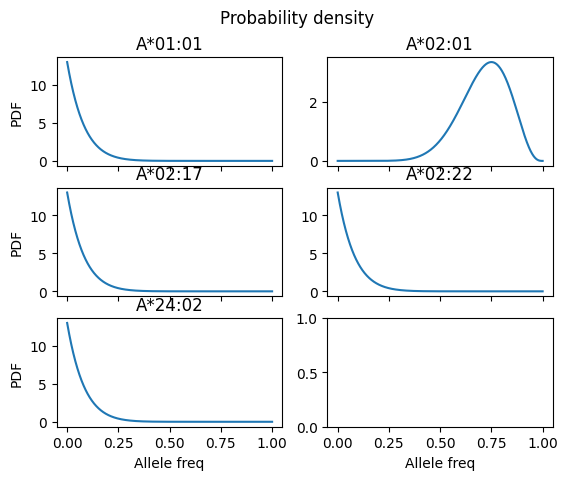

In [4]:
manual_prior = [1, 10, 1, 1, 1]

# View prior distribution
HLAfreq.plot_prior(concentration=manual_prior, labels=cafV.allele)

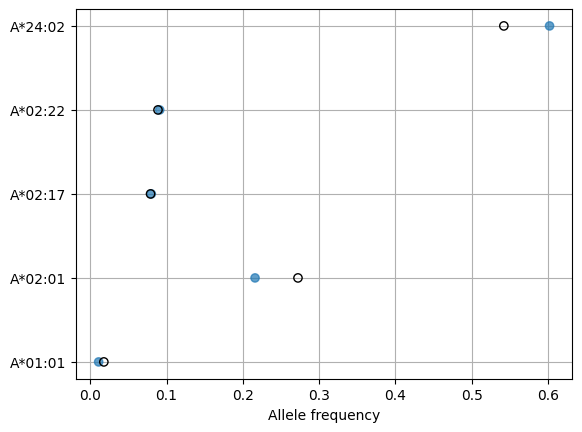

In [5]:
# Combine Allele Freq of study with Manual Prior
cafMP = HLAfreq.combineAF(venezuelaAF, alpha=manual_prior)

# View posterior
HLAfreq.plotAF(cafMP, AFtab=venezuelaAF)

Alternatively we can use another population as our prior.
For example we will use data for Colombia, a neighbouring country
with many more samples for HLA A.

When using other studies as a prior we can downweight their samples
so they count less than the samples in our actual population.
The amount of downweighting depends on how relevent you believe the
other study is. Here we arbitrarily downweight by a factor 0.01 as
an example so that the Venezuela data is not drowned out by the Colombia data.

When recalculating the prior to plot, sample size is doubled
as each person in the study is diploid and so provides two alleles.

In [6]:
# Download data for Colombia
country = "Colombia"
base_url = HLAfreq.makeURL(country, locus="A", standard="g",)
colombiaAF = HLAfreq.getAFdata(base_url)

1 pages of results
Download complete


In [7]:
# Combine Colombia studies into a national average
colombiaAF = HLAfreq.only_complete(colombiaAF)
colombiaAF = HLAfreq.decrease_resolution(colombiaAF, 2)
cafC = HLAfreq.combineAF(colombiaAF)
cafC['population'] =  'Colombia'

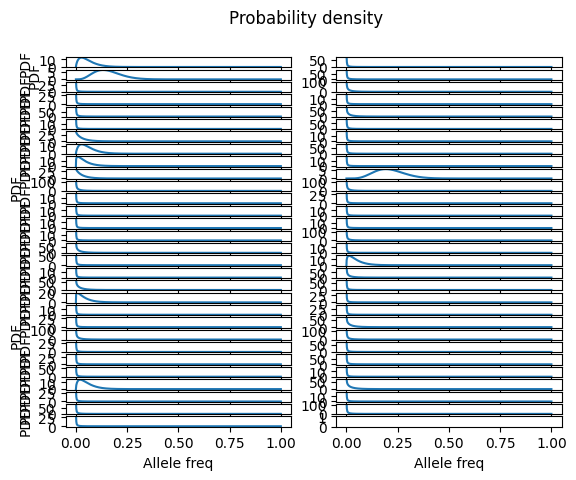

In [8]:
# Create a prior from Colombia
study_prior = cafC.copy()
study_prior.sample_size = study_prior.sample_size * 0.01

# View prior
HLAfreq.plot_prior(
    concentration = (2 * study_prior.sample_size * study_prior.allele_freq).tolist()
)


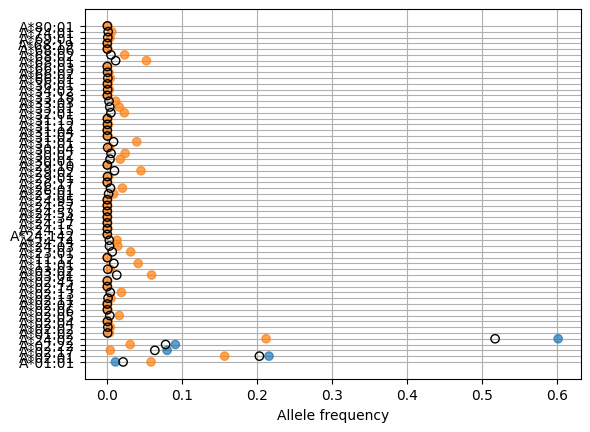

In [9]:
# Allele Frequency TABle with Study Prior
AFtabSP = pd.concat([venezuelaAF, study_prior], join="inner")

# Combine Allele Frequency with Study Prior
# As we're using a dataset as the prior we should set the
# argument for priors, `alpha` to 0. 59 Is the number all alleles
# in our dataset
nalleles = len(AFtabSP.allele.unique())
cafSP = HLAfreq.combineAF(AFtabSP, alpha=[0]*nalleles)

# View posterior of all alleles
HLAfreq.plotAF(cafSP, AFtabSP)


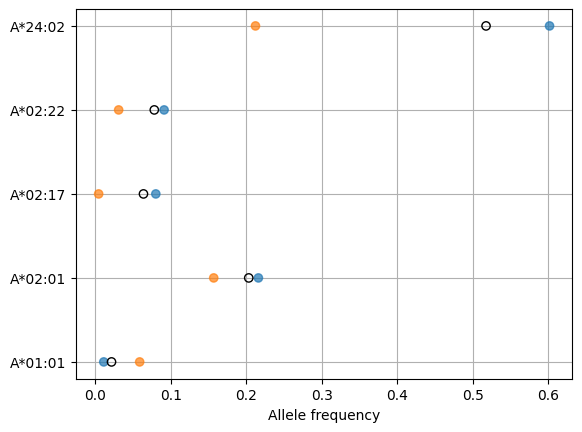

In [10]:
# View posterior of just alleles observed in Venezuela

venezuela_alleles = cafV.allele
HLAfreq.plotAF(
    cafSP[cafSP.allele.isin(venezuela_alleles)],
    AFtabSP[AFtabSP.allele.isin(venezuela_alleles)]
)

## Alternate priors
As the amount of data increases, the choice of prior has less and less impact on the posterior estimates. However, priors can have an unexpectedly large impact when working with large numbers of alleles (because the sum of the prior also increases). Fortunately this mainly affects the compound model (fit using `AFhdi()` to estimate credible intervals and "post_mean"), but if you are using this it is important to check your results and see the impact of alternate priors.

We can diagnose the problem easily using `plotAF()`.

1 pages of results
Download complete
2    80
3     3
4     2
Name: allele, dtype: int64
Multiple resolutions in AFtab. Fix with decrease_resolution()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.



There are several possible reasons, see the credible intervals example: https://github.com/Vaccitech/HLAfreq/blob/main/examples/credible_intervals.ipynb
If you have set `credible_interval` to < 0.95, this may be a non-issue.


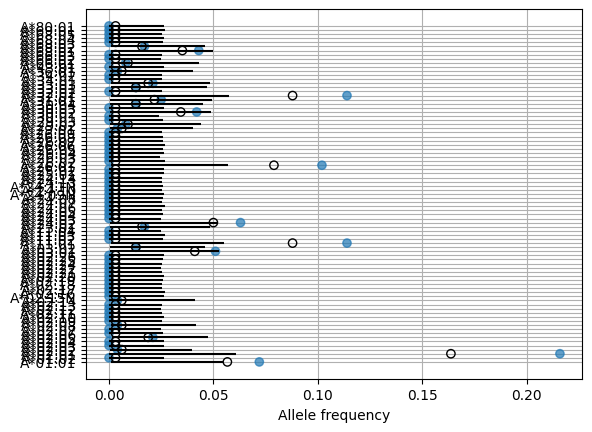

In [11]:
country = "Oman"
locus = "A"

# Download dataset
base_url = HLAfreq.makeURL(country, locus=locus)
aftab = HLAfreq.getAFdata(base_url)
aftab = HLAfreq.only_complete(aftab)
HLAfreq.check_resolution(aftab)
aftab = HLAfreq.decrease_resolution(aftab, 2)
caf = HLAfreq.combineAF(aftab)
# Calculate high density intervals
hdi = HLAhdi.AFhdi(aftab, credible_interval=0.95)

# Plot data
HLAfreq.plotAF(caf, aftab, hdi=hdi)

The issue becomes even clearer if we compare the default model and compound model estimates directly. In the plot below, the dashed line shows agreement between the default and compound models. In this case, the compound model is overestimating rare alleles and under estimating common alleles. In other words, all allele estimates are being dragged towards equal frequency.

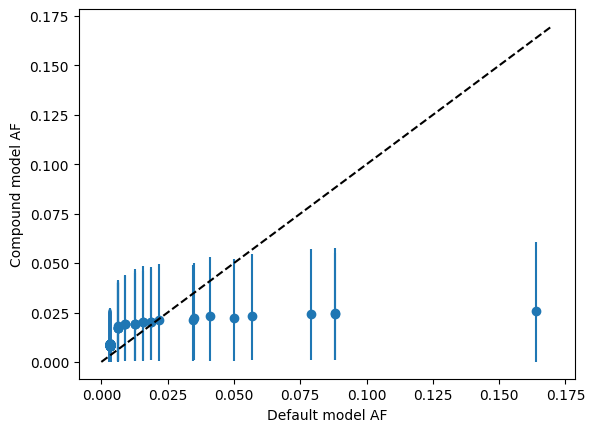

In [12]:
plt.scatter(caf.allele_freq, hdi.post_mean)
plt.vlines(caf.allele_freq, hdi.lo, hdi.hi)
plt.plot([0,.17], [0,.17], c="black", linestyle="--")
plt.xlabel('Default model AF')
plt.ylabel('Compound model AF')
plt.show()

The above plots clearly shows disacreement between the default and compound model which indicates an issue with out choice of prior. This is an example of how our defult prior (all $1$ s) can be a problem with many alleles. It's important to note though that this is a very small dataset (one study) and this will not be a problem for larger datases until the number of alleles is much higher.

We can solve this by using smaller values in our prior, e.g. $1/k$ where $k$ is the number of alleles. This is known as Perks prior. Unfortunately models with this prior take longer to fit (minutes rather than seconds). It is also particularly important to validate models that use this prior with [posterior predictive checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) and as described in the [credible intervals example](https://github.com/Vaccitech/HLAfreq/blob/main/examples/credible_intervals.ipynb).

Using this $1/k$ prior we can see that the credible intervals are no longer dragged to zero and better reflect the observed data.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 293 seconds.



There are several possible reasons, see the credible intervals example: https://github.com/Vaccitech/HLAfreq/blob/main/examples/credible_intervals.ipynb
If you have set `credible_interval` to < 0.95, this may be a non-issue.


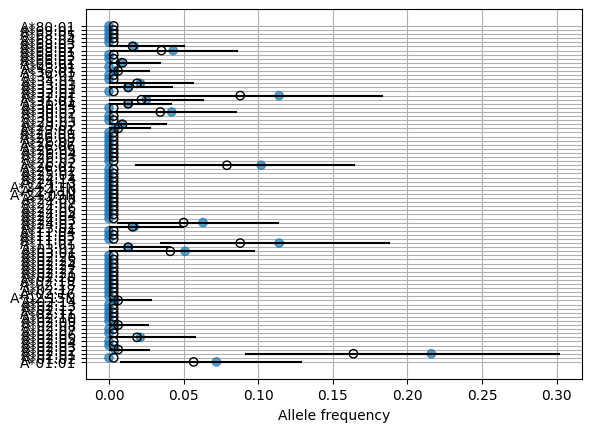

In [13]:
k = caf.shape[0]
perks_hdi = HLAhdi.AFhdi(aftab, credible_interval=0.95, prior=[1/k]*k)
HLAfreq.plotAF(caf, aftab, hdi=perks_hdi)

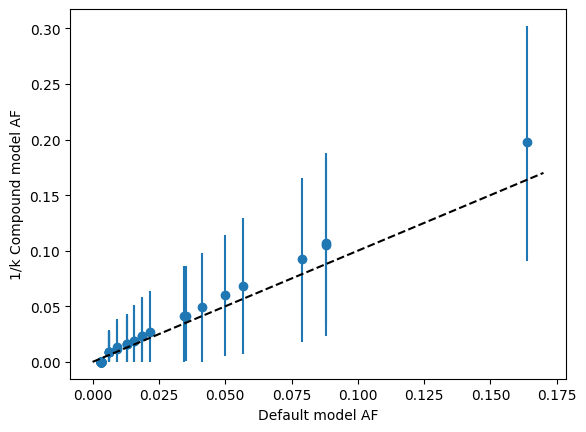

In [15]:
plt.scatter(caf.allele_freq, perks_hdi.post_mean)
plt.vlines(caf.allele_freq, perks_hdi.lo, perks_hdi.hi)
plt.plot([0,.17], [0,.17], c="black", linestyle="--")
plt.xlabel('Default model AF')
plt.ylabel('1/k Compound model AF')
plt.show()